In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
from __future__ import print_function
import numpy as np
import pandas as pd
import sys
import os
import io
import tensorflow as tf
print(tf.__version__)
import codecs
from keras.callbacks import LambdaCallback, ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Bidirectional, Embedding, BatchNormalization, LeakyReLU
from keras.models import load_model
from tensorflow.keras.utils import plot_model

2.4.1


In [3]:
sequence_length=10
min_word_frequency=10
step=1
batch_size=150

**Shuffle and split training set**

In [4]:
def shuffle_and_split_training_set(sentences_original, next_original, percentage_test=2):
  print("Shuffling sentences...")
  tmp_sentences=[]
  tmp_next_word=[]
  for i in np.random.permutation(len(sentences_original)):
    tmp_sentences.append(sentences_original[i])
    tmp_next_word.append(next_original[i])
  cut_index=int((1-((percentage_test)/100.0))*len(sentences_original))
  x_train, x_test=tmp_sentences[:cut_index], tmp_sentences[cut_index:]
  y_train, y_test=tmp_next_word[:cut_index], tmp_next_word[cut_index:]
  print("Size of training set=", len(x_train))
  print("Size of test set=", len(y_test))
  return (x_train, x_test), (y_train, y_test)

**Generator function**

In [5]:
def generator(sentence_list, next_word_list, batch_size):
  index=0
  while True:
    x=np.zeros((batch_size, sequence_length), dtype=np.int32)
    y=np.zeros((batch_size), dtype=np.int32)
    for i in range(batch_size):
      for t, w in enumerate(sentence_list[index%len(sentence_list)]):
        x[i, t]=word_indices[w]
      y[i]=word_indices[next_word_list[index%len(sentence_list)]]
      index+=1                                             
    yield x, y

**Write generated vocabulary to a file**

In [6]:
def print_vocabulary(words_file_path, words_set):
  words_file=codecs.open(words_file_path, 'w', encoding='utf8')
  for w in words_set:
    if (w!='\n'):
      words_file.write(w+"\n")
    else:
      words_file.write(w)
  words_file.close()

**Build an LSTM Model**

In [7]:
def get_model(dropout=0.2):
    print('Build model...')
    model=tf.keras.Sequential()
    model.add(Embedding(input_dim=len(words), output_dim=1024))
    model.add(Bidirectional(LSTM(batch_size*7)))
    if dropout > 0:
        model.add(Dropout(dropout))

    model.add(Dense(batch_size*4))
    model.add(LeakyReLU(alpha=0.1))

    if dropout > 0:
        model.add(Dropout(dropout))

    model.add(Dense(batch_size*4))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    
    if dropout > 0:
        model.add(Dropout(dropout))

    model.add(Dense(len(words)))
    model.add(Activation('softmax'))
    print("Done!")
    return model

In [8]:
def sample(preds, temperature=1.0):
  preds=np.asarray(preds).astype('float64')
  preds=np.log(preds)/temperature
  exp_preds=np.exp(preds)
  preds=exp_preds/sum(exp_preds)
  probas=np.random.multinomial(1, preds, 1)
  return np.argmax(probas)

**Behavior at the end of an epoch**

In [9]:
def on_epoch_end(epoch, logs):
  examples_file.write("\n---Generating text after epoch %d\n"%epoch)
  seed_index=np.random.randint(len(sentences_train+sentences_test))
  seed=(sentences_train+sentences_test)[seed_index]
  diversity_array=np.arange(0.3, 0.8, 0.1)
  for diversity in diversity_array:
    sentence=seed
    diversity_string="\n---Diversity=%s.\n"%str(diversity)
    joined=' '.join(sentence)
    seed_sentence="\n---Seed sentence:%s.\n"%joined
    examples_file.write(diversity_string)
    examples_file.write(seed_sentence)
    examples_file.write(joined)
    examples_file.write('\n')
    for i in range(50):
      x_pred=np.zeros((1, sequence_length))
      for t, word in enumerate(sentence):
        x_pred[0, t]= word_indices[word]
      ##print("Generating predictions...")
      preds=model.predict(x_pred, verbose=0)[0]
      #print("Done!")
      #print("Generating next index...")
      next_index=sample(preds, diversity)
      #print("Done!")
      #print("Generating next word...")
      next_word=indices_word[next_index]
      #print("Done!")
      #print("Updating sentence value...")
      sentence=sentence[1:]
      #print("Done!")
      #print("Appending to sentence...")
      sentence.append(next_word)
      #print("Done!!!!!!!!!")
    examples_file.write(" "+next_word)
  examples_file.write("\n")
  examples_file.flush()

**Stephen R. Donaldson**

In [10]:
corpus='/content/gdrive/MyDrive/Project folder/Author text files/Stephen R. Donaldson.txt'
examples='/content/gdrive/MyDrive/Project folder/Authorwise examples/examples_stephen_r_donaldson.txt'
vocabulary='/content/gdrive/MyDrive/Project folder/Authorwise vocabulary/vocabulary_stephen_r_donaldson.txt'

In [11]:
if not os.path.isdir('/content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/checkpoints'):
  os.makedirs('/content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/checkpoints')

In [12]:
#with io.open(corpus, encoding='utf-8') as file:
file=open(corpus, encoding='utf8')
text=file.read().lower().replace('\n', '\n ')
print('Corpus length in characters=', len(text))

Corpus length in characters= 28471251


In [13]:
text_in_words=[w for w in text.split(' ') if w.strip()!='' or w=='\n']
print("Corpus length in words=", len(text_in_words))

Corpus length in words= 4893213


In [14]:
word_freq={}
for word in text_in_words:
  word_freq[word]=1+word_freq.get(word, 0)

In [15]:
len(word_freq)

72920

In [16]:
ignored_words=set('\n')
for k, v in word_freq.items():
  if word_freq[k]<min_word_frequency:
    ignored_words.add(k)

In [17]:
words=set(text_in_words)
print("Unique words before ignoring:", len(words))
words=sorted(set(text_in_words)-ignored_words)
print("Unique words after ignoring:", len(words))
print_vocabulary(vocabulary, words)

Unique words before ignoring: 72920
Unique words after ignoring: 22051


In [18]:
word_indices=dict((c, i) for i, c in enumerate(words))
indices_word=dict((i, c) for i, c in enumerate(words))

In [19]:
sentences=[]
next_words=[]
ignored=0
print("Generating sequences...", end="")
for i in range(0, len(text_in_words)-sequence_length, step):
  if (len(set(text_in_words[i:i+sequence_length+1]).intersection(ignored_words))==0):
    sentences.append(text_in_words[i:i+sequence_length])
    next_words.append(text_in_words[i+sequence_length])
  else:
    ignored+=1
print("Done!")

Generating sequences...Done!


In [22]:
print("Total ignored sequences: ", ignored)
print("Remaning sentences: ", len(sentences))
print("Number of words: ", len(next_words))

Total ignored sequences:  1644300
Remaning sentences:  3248903
Number of words:  3248903


In [23]:
(sentences_train, sentences_test), (next_words_train, next_words_test)=shuffle_and_split_training_set(sentences, next_words)

Shuffling sentences...
Size of training set= 3183924
Size of test set= 64979


In [24]:
model=get_model()

Build model...
Done!


In [25]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

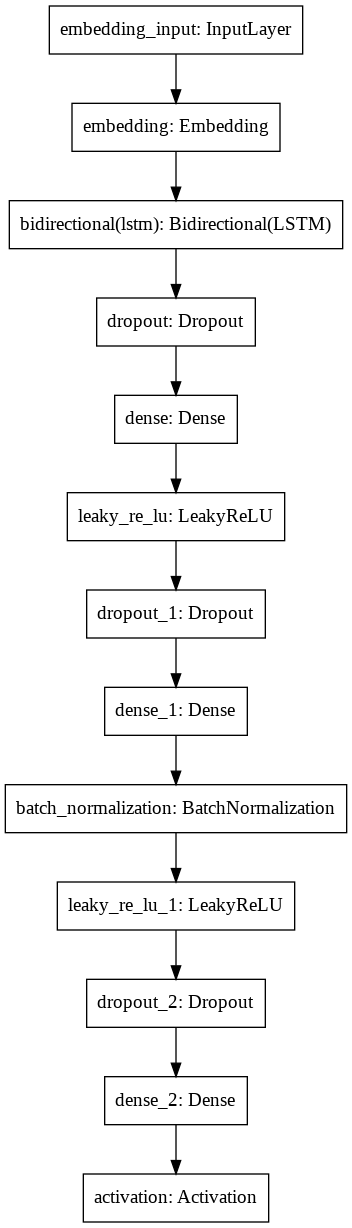

In [26]:
plot_model(model, to_file='Stephen R. Donaldson Model.png')

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, None, 1024)        12563456  
_________________________________________________________________
bidirectional_9 (Bidirection (None, 2100)              17430000  
_________________________________________________________________
dropout_20 (Dropout)         (None, 2100)              0         
_________________________________________________________________
dense_20 (Dense)             (None, 600)               1260600   
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 600)               0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 600)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 600)              

In [ ]:
examples_file=open(examples, "w")

In [ ]:
file_path = "//content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/checkpoints/METG-epoch{epoch:03d}-words%d-sequence%d-minfreq%d-" \
                "loss{loss:.4f}-accuracy{accuracy:.4f}-val_loss{val_loss:.4f}-val_accuracy{val_accuracy:.4f}" % \
                (len(words), sequence_length, min_word_frequency)

In [ ]:
checkpoint=ModelCheckpoint(file_path, monitor='val_accuracy', save_best_only=True)
print_callback=LambdaCallback(on_epoch_end=on_epoch_end)
early_stopping=EarlyStopping(monitor='val_accuracy', patience=2)
callbacks_list=[checkpoint, print_callback, early_stopping]

In [ ]:
int(len(sentences_test)/batch_size)+1

117

In [ ]:
with tf.device('/gpu:0'):
  history=model.fit_generator(generator(sentences_train, next_words_train, batch_size), 
                    steps_per_epoch=int(len(sentences_train)/batch_size)+1, 
                    epochs=40, 
                    callbacks=callbacks_list, 
                    validation_data=generator(sentences_test, next_words_test, batch_size), 
                    validation_steps=int(len(sentences_test)/batch_size)+1)
from keras.models import model_from_json
model_json=model.to_json()
with open("/content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/model_stephen_r_donaldson.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/model_stephen_r_donaldson.h5")
print("Saved model to disk!")

Epoch 1/40
   1/5698 [..............................] - ETA: 14:53 - loss: 6.5329 - accuracy: 0.0800

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


5698/5698 [==============================] - 880s 154ms/step - loss: 5.7666 - accuracy: 0.1456 - val_loss: 5.2695 - val_accuracy: 0.1715


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/checkpoints/METG-epoch001-words12269-sequence10-minfreq10-loss5.7666-accuracy0.1456-val_loss5.2695-val_accuracy0.1715/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/checkpoints/METG-epoch001-words12269-sequence10-minfreq10-loss5.7666-accuracy0.1456-val_loss5.2695-val_accuracy0.1715/assets


Epoch 2/40
5698/5698 [==============================] - 878s 154ms/step - loss: 5.1208 - accuracy: 0.1799 - val_loss: 4.9869 - val_accuracy: 0.1884


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/checkpoints/METG-epoch002-words12269-sequence10-minfreq10-loss5.1208-accuracy0.1799-val_loss4.9869-val_accuracy0.1884/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/checkpoints/METG-epoch002-words12269-sequence10-minfreq10-loss5.1208-accuracy0.1799-val_loss4.9869-val_accuracy0.1884/assets


Epoch 3/40
5698/5698 [==============================] - 878s 154ms/step - loss: 4.8559 - accuracy: 0.1953 - val_loss: 4.8556 - val_accuracy: 0.2008


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/checkpoints/METG-epoch003-words12269-sequence10-minfreq10-loss4.8559-accuracy0.1953-val_loss4.8556-val_accuracy0.2008/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/checkpoints/METG-epoch003-words12269-sequence10-minfreq10-loss4.8559-accuracy0.1953-val_loss4.8556-val_accuracy0.2008/assets


Epoch 4/40
5698/5698 [==============================] - 875s 154ms/step - loss: 4.6748 - accuracy: 0.2063 - val_loss: 4.7780 - val_accuracy: 0.2073


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/checkpoints/METG-epoch004-words12269-sequence10-minfreq10-loss4.6748-accuracy0.2063-val_loss4.7780-val_accuracy0.2073/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/checkpoints/METG-epoch004-words12269-sequence10-minfreq10-loss4.6748-accuracy0.2063-val_loss4.7780-val_accuracy0.2073/assets


Epoch 5/40
5698/5698 [==============================] - 875s 154ms/step - loss: 4.5277 - accuracy: 0.2165 - val_loss: 4.7389 - val_accuracy: 0.2151


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/checkpoints/METG-epoch005-words12269-sequence10-minfreq10-loss4.5277-accuracy0.2165-val_loss4.7389-val_accuracy0.2151/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/checkpoints/METG-epoch005-words12269-sequence10-minfreq10-loss4.5277-accuracy0.2165-val_loss4.7389-val_accuracy0.2151/assets


Epoch 6/40
5698/5698 [==============================] - 879s 154ms/step - loss: 4.3999 - accuracy: 0.2263 - val_loss: 4.7200 - val_accuracy: 0.2177


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/checkpoints/METG-epoch006-words12269-sequence10-minfreq10-loss4.3999-accuracy0.2263-val_loss4.7200-val_accuracy0.2177/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/checkpoints/METG-epoch006-words12269-sequence10-minfreq10-loss4.3999-accuracy0.2263-val_loss4.7200-val_accuracy0.2177/assets


Epoch 7/40
5698/5698 [==============================] - 880s 154ms/step - loss: 4.2819 - accuracy: 0.2351 - val_loss: 4.7225 - val_accuracy: 0.2188


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/checkpoints/METG-epoch007-words12269-sequence10-minfreq10-loss4.2819-accuracy0.2351-val_loss4.7225-val_accuracy0.2188/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/checkpoints/METG-epoch007-words12269-sequence10-minfreq10-loss4.2819-accuracy0.2351-val_loss4.7225-val_accuracy0.2188/assets


Epoch 8/40
5698/5698 [==============================] - 878s 154ms/step - loss: 4.1742 - accuracy: 0.2437 - val_loss: 4.7273 - val_accuracy: 0.2216


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/checkpoints/METG-epoch008-words12269-sequence10-minfreq10-loss4.1742-accuracy0.2437-val_loss4.7273-val_accuracy0.2216/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/checkpoints/METG-epoch008-words12269-sequence10-minfreq10-loss4.1742-accuracy0.2437-val_loss4.7273-val_accuracy0.2216/assets


Epoch 9/40
5698/5698 [==============================] - 877s 154ms/step - loss: 4.0725 - accuracy: 0.2512 - val_loss: 4.7498 - val_accuracy: 0.2227


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/checkpoints/METG-epoch009-words12269-sequence10-minfreq10-loss4.0725-accuracy0.2512-val_loss4.7498-val_accuracy0.2227/assets


INFO:tensorflow:Assets written to: //content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/checkpoints/METG-epoch009-words12269-sequence10-minfreq10-loss4.0725-accuracy0.2512-val_loss4.7498-val_accuracy0.2227/assets


Epoch 10/40
5698/5698 [==============================] - 877s 154ms/step - loss: 3.9793 - accuracy: 0.2587 - val_loss: 4.7860 - val_accuracy: 0.2213
Epoch 11/40
5698/5698 [==============================] - 878s 154ms/step - loss: 3.8874 - accuracy: 0.2671 - val_loss: 4.8061 - val_accuracy: 0.2185
Saved model to disk!


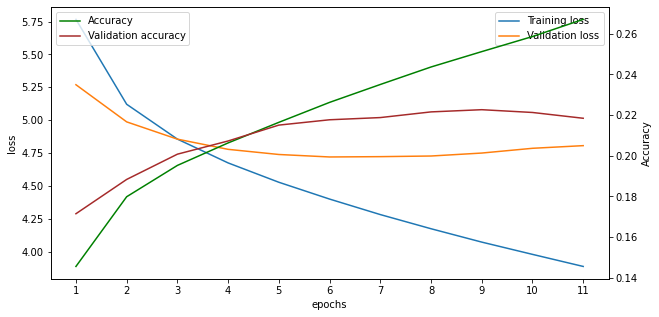

In [ ]:
import matplotlib.pyplot as plt
num_epochs=11

fig,(ax1)=plt.subplots(figsize=(10, 5))
ax2=ax1.twinx()

ax1.plot(range(1, num_epochs+1), history.history['loss'])
ax1.plot(range(1, num_epochs+1), history.history['val_loss'])

ax2.plot(range(1, num_epochs+1), history.history['accuracy'], color='green')
ax2.plot(range(1, num_epochs+1), history.history['val_accuracy'], color='brown')
plt.xticks(list(range(1, num_epochs+1)))

ax1.legend(['Training loss', 'Validation loss'])
ax2.legend(['Accuracy', 'Validation accuracy'])

ax1.set_xlabel('epochs')
ax1.set_ylabel('loss')
ax2.set_ylabel('Accuracy')

plt.show()

In [ ]:
model_file="/content/gdrive/MyDrive/Project folder/Authorwise text generation/Stephen R. Donaldson/checkpoints/METG-epoch009-words12269-sequence10-minfreq10-loss4.0725-accuracy0.2512-val_loss4.7498-val_accuracy0.2227"
from keras.models import load_model
model=load_model(model_file)

In [ ]:
##model=get_model()
model.load_weights("/content/gdrive/MyDrive/Project folder/Authorwise text generation/model_stephen_r_donaldson.h5")

In [ ]:
#history_1=model.fit_generator(generator(sentences_train, next_words_train, batch_size), 
#                  steps_per_epoch=int(len(sentences_train)/batch_size)+1, 
#                  epochs=10, 
#                  callbacks=callbacks_list, 
#                  validation_data=generator(sentences_test, next_words_test, batch_size), 
#                  validation_steps=int(len(sentences_test)/batch_size)+1)

**Generate Text**

In [ ]:
def generate_text(model, indices_word, word_indices, 
                  seed, sequence_length, diversity, 
                  quantity, vocabulary, write_path, 
                  write_to_file=False, authorname=""):
  sentence=seed.split(" ")
  print("====Generating text====")
  print("Diversity: ", diversity)
  print("Seed sentence:",seed)
  counter=1
  full_appended_sentence=seed
  print(seed, end="")
  for i in range(quantity):
    x_pred=np.zeros((1, sequence_length))
    for t, word in enumerate(sentence):
      x_pred[0, t]= word_indices[word]
    ##print("Generating predictions...")
    preds=model.predict(x_pred, verbose=0)[0]
    next_index=sample(preds, diversity)
    next_word=indices_word[next_index]
    sentence=sentence[1:]
    sentence.append(next_word)
    print(" "+word, end="")
    full_appended_sentence=full_appended_sentence+" "+word
    if (counter%10==0):
      print("")
      full_appended_sentence=full_appended_sentence+"\n"
    counter+=1
  print("\n")
  if (write_to_file is True):
    filename=write_path+authorname+"_"+str(diversity)+"_"+str(quantity)+".txt"
    print("Writing to file...", end="")
    f=open(filename, "w")
    f.write(full_appended_sentence)
    print("Done!")
    f.close()

In [ ]:
##vocabulary_file="/content/gdrive/MyDrive/Project folder/Authorwise vocabulary/vocabulary_stephen_r_donaldson.txt"

In [ ]:
##model=load_model(model_file)
##vocabulary=open(vocabulary_file, "r").readlines()
##print(len(vocabulary))

In [ ]:
#import re
#vocabulary = sorted(set([re.sub(r'(\S+)\s+', r'\1', w) for w in vocabulary]))

In [ ]:
#word_indices=dict((c, i) for i, c in enumerate(words))
#indices_word=dict((i, c) for i, c in enumerate(words))

For generating essays with 250 words.

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=250
  generate_text(model, indices_word, word_indices, 
                seed, sequence_length, diversity, 
                quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Stephen R. Donaldson/", 
                True, "Stephen R. Donaldson")
  print("=====================================================")

Seed sentence: her desire for freedom and sunshine, and let the curtain
====Generating text====
Diversity:  0.3
Seed sentence: her desire for freedom and sunshine, and let the curtain
her desire for freedom and sunshine, and let the curtain curtain come to the company. the next dawn, the sun
 was rising. the next dawn, the sun was rising. the
 air was slick with dust. he did not move. the
 next dawn, he found that he was not looking at
 her. he was not ready to save him. he had
 been able to save his life. he had no idea
 how badly he had been able to save his life.
 he had no power to raise his head. he had
 no idea how badly she had been able to save
 him. she was not ready to think about the condition
 of her actions. she had no other choice, she would
 have to do something about the haruchai. and she had
 to do something about it. she had been able to
 save herself. and she had not been able to do
 so. she had not been able to save her son.
 she had been so badly paralyzed by her o

For generating a small essay of 300 words.

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=300
  generate_text(model, indices_word, word_indices, 
                seed, sequence_length, diversity, 
                quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Stephen R. Donaldson/", 
                True, "Stephen R. Donaldson")
  print("=====================================================")

Seed sentence: for him; she went out of her way to supply
====Generating text====
Diversity:  0.3
Seed sentence: for him; she went out of her way to supply
for him; she went out of her way to supply supply the creature in order to make a mistake. and
 the waynhim were not alone. they were not alone. they
 were the first of the search, and their own purpose
 had been slain for the sake of the old man’s
 vulnerability. a master may have been a form of power.
 but the next morning, she felt that she had not
 been able to perceive the implications of her own use.
 in her own way, she had been able to do
 so from the sunbane. she had been so badly paralyzed
 by the fact that she had been given to him
 in the land. he had become the guardian of the
 one tree, bringing his life to the land. he had
 been summoned to the land in order to describe their
 own forms. they were not alone. they were not alone.
 they had not been summoned to the land, and the
 masters were not certain that they were 

For generating novels with 10000 words

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=10000
  generate_text(model, indices_word, word_indices, 
                seed, sequence_length, diversity, 
                quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Stephen R. Donaldson/", 
                True, "Stephen R. Donaldson")
  print("=====================================================")

Streaming output truncated to the last 5000 lines.
 one hand, she hugged her fingers as if she were
 trying to sway the rest of the krill ; but
 he was not yet too eager for anything except the
 long ordeal of the land in order to keep his
 thoughts while he finds that he has no friend but
 people who do not desire you to make to go
 to your aid. as i have given yourself so that
 you will not be undone from my purpose. if you
 will not fail, however he must assail or counsel us,
 and because the ur-lord does not appear to be a
 village in the land’s plight. and how do you think
 we can make to do anything about your story. i’m
 just a healer. but i don’t know what foul wants
 to do,” she said with her hands and arms as
 though her own fears were being torn from her. the
 haruchai had not moved. abruptly, she looked at her shoulder
 as if she were being torn apart. but the pain
 was his. she did not know how to deny him.
 his gaze was fixed on her as she continued. “if
 you are indeed a

For generating novels with 10500 words.

In [ ]:
seed_index=np.random.randint(len(sentences_train+sentences_test))
seed=(sentences_train+sentences_test)[seed_index]
seed=" ".join(seed)
print("==========================================")
print("Seed sentence:", seed)
print("==========================================")
diversity_array=np.arange(0.3, 1.1, 0.1)
for diversity in diversity_array:
  quantity=10500
  generate_text(model, indices_word, word_indices, seed, sequence_length, diversity, quantity, words, 
                "/content/gdrive/MyDrive/Project folder/Author text generation/Stephen R. Donaldson/", True, "Stephen R. Donaldson")
  print("=====================================================")

Streaming output truncated to the last 5000 lines.
 whether they were not afraid. the next day, the fire
 was high in the light as if they were about
 to fall in search of the sunbane. but the next
 morning, she had come too far to be able to
 endure the land from hearing the burden of his doom.
 and she had done this to her the price of
 the caesures. she had sacrificed herself to the land’s essential
 nature and her own. in her own way, she had
 spent too much time learning to hurl her thoughts around
 herself. she had not expected to do something to you?
 but the ramen were not ready. the land had been
 born and did not rest for the first place. and
 the bloodguard went on to the left, “my army has
 been made to meet the forces of the earth, and
 to the land in the name of the earth, they
 would be given to the land of the land’s need,
 they will speak of the approach of the lords, and
 to the earth, we would not have been able to
 recognize the nature of his emotions. but her path 